In [ ]:
import wandb
import equinox as eqx
import os 

# Foundational SSM imports
from omegaconf import OmegaConf
import tempfile 
from foundational_ssm.models import SSMDownstreamDecoder
from foundational_ssm.utils import h5_to_dict
from foundational_ssm.transform import smooth_spikes
import jax

%load_ext autoreload
%autoreload 2

def load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=SSMDownstreamDecoder):
    """Load model, optimizer state, epoch, and step from a checkpoint file."""
    api = wandb.Api()
    try:
        artifact = api.artifact(artifact_full_name, type="checkpoint")
    except Exception as e:
        raise FileNotFoundError(f"Could not find checkpoint artifact: {artifact_full_name}")
    
    run = artifact.logged_by()
    run_cfg = OmegaConf.create(run.config)
    model_cfg = OmegaConf.create(run_cfg.model)
    model_template, state_template = eqx.nn.make_with_state(model_cls)(
        **model_cfg,
    )
    
    with tempfile.TemporaryDirectory() as temp_dir:
        artifact.download(temp_dir)
        model = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "model.ckpt"), model_template)
        state = eqx.tree_deserialise_leaves(os.path.join(temp_dir, "state.ckpt"), state_template)

    meta = artifact.metadata
    return model, state, meta

wandb:   3 of 3 files downloaded.  


In [ ]:
layer = "2"
pretrain_mode = "scratch"
train_mode = "freeze_a"
alias = "best" # can be latest/best/ epoch_{any value in range(0,1000,100)}
# epoch 0 now stores a fresh model.
artifact_full_name = f"melinajingting-ucl/foundational_ssm_rtt/l{layer}_{pretrain_mode}_{train_mode}_checkpoint:{alias}"
model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name)

In [ ]:
# Download mc_rtt_trialized from https://huggingface.co/datasets/MelinaLaimon/nlb_processed/tree/main
# Edit dataset_dir to your directory
dataset_dir = "../../data/foundational_ssm/processed/nlb" 
dataset_path = os.path.join(dataset_dir, "mc_rtt_trialized.h5")
data = h5_to_dict(dataset_path)
data["neural_input"] = smooth_spikes(data["neural_input"], kern_sd_ms=20, bin_size_ms=5, time_axis=1)
input = data["neural_input"]
target = data["behavior_input"]

# Specify the layers you want to generate the activations of. 
# ["post_encoder", "ssm_pre_activation", "ssm_post_activation"]
layer_keys = ["ssm_pre_activation"] 
inf_model = eqx.nn.inference_mode(model) # Switches off dropout
output, _, activations = jax.vmap(inf_model.call_with_activations, axis_name="batch", in_axes=(0, None, None))(input, state, layer_keys)

# Example Plotting Output

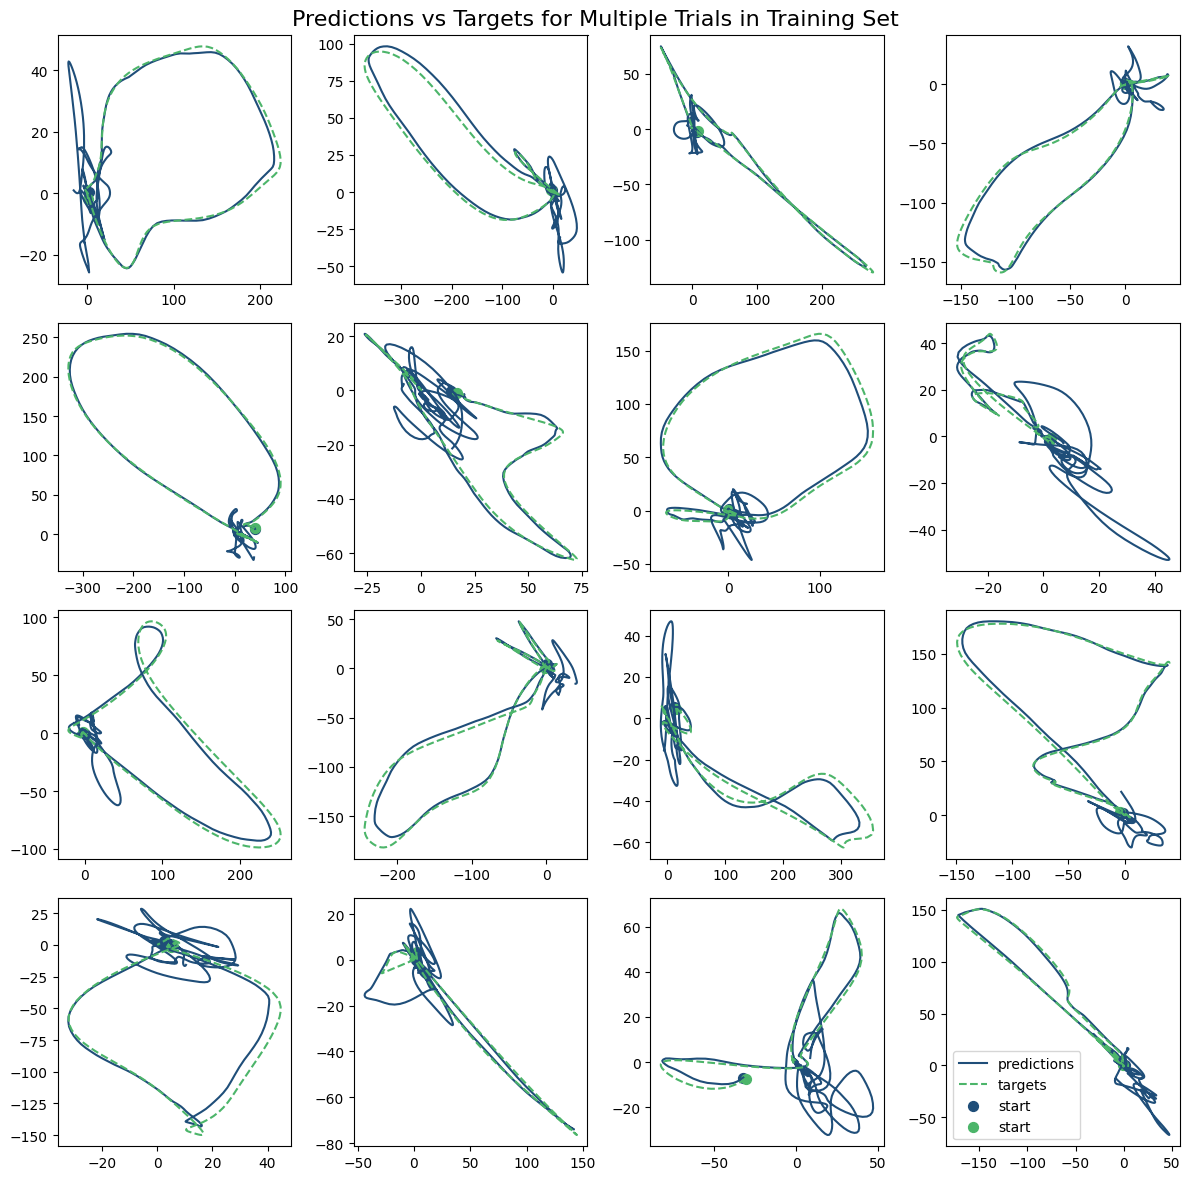

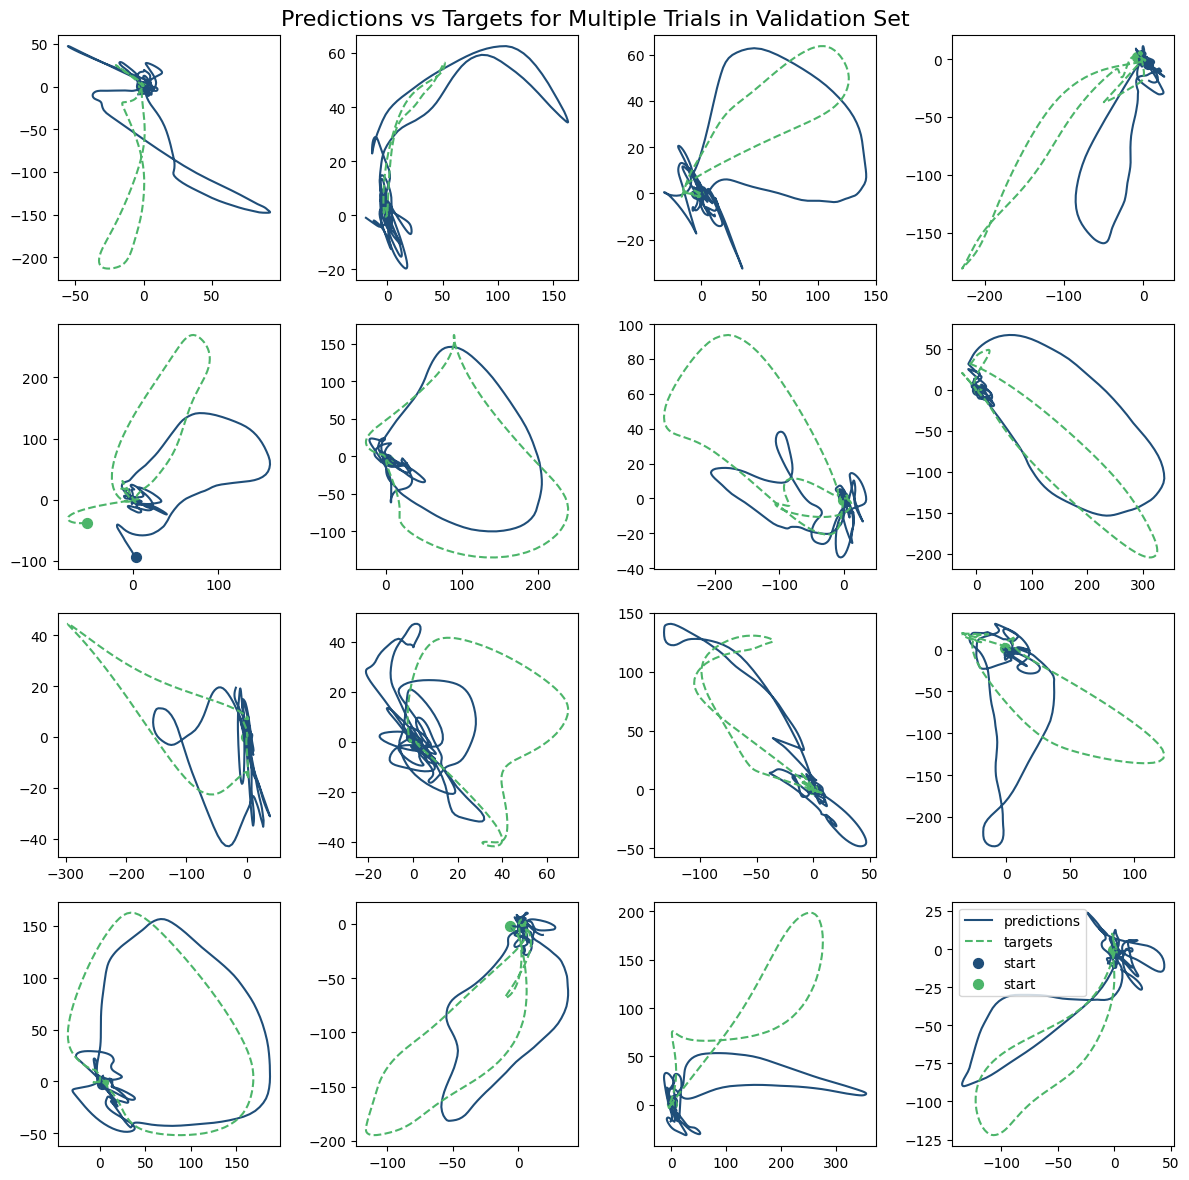

In [ ]:
import matplotlib.pyplot as plt 

skip_timesteps = 56 # IMPORTANT - we had prepended 279ms of history, and used 5ms bins

colors = {
    'target': "#4CB56A",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}
fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 0
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(output[trial_id,skip_timesteps:,0], output[trial_id,skip_timesteps:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(target[trial_id,skip_timesteps:,0], target[trial_id,skip_timesteps:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(output[trial_id,skip_timesteps,0], output[trial_id,skip_timesteps,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(target[trial_id,skip_timesteps,0], target[trial_id,skip_timesteps,1], color=colors['target'], s=50, label='start')

fig.suptitle('Predictions vs Targets for Multiple Trials in Training Set', fontsize=16)
axs[i].legend()
plt.tight_layout()

fig, axs = plt.subplots(4, 4, figsize=(12, 12))
axs = axs.flatten()
starting_trial_id = 379
for i in range(16):
    trial_id = starting_trial_id + i
    # plot trajectories of predictions and targets, add a dot at start and arrow at end. 
    axs[i].plot(output[trial_id,skip_timesteps:,0], output[trial_id,skip_timesteps:,1], label='predictions', color=colors['prediction'])
    axs[i].plot(target[trial_id,skip_timesteps:,0], target[trial_id,skip_timesteps:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(output[trial_id,skip_timesteps,0], output[trial_id,skip_timesteps,1], color=colors['prediction'], s=50, label='start')
    axs[i].scatter(target[trial_id,skip_timesteps,0], target[trial_id,skip_timesteps,1], color=colors['target'], s=50, label='start')

fig.suptitle('Predictions vs Targets for Multiple Trials in Validation Set', fontsize=16)
axs[i].legend()
plt.tight_layout()